In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import auc,accuracy_score,precision_score,recall_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids,TomekLinks,NeighbourhoodCleaningRule,NearMiss

def down_sampling(X,y,down_sampling_type,info):
    '''refer : https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-i-under-sampling-a8dbc3d8d6d8'''
    
    #random under sampling
    if down_sampling_type == 'random':
        sampler = RandomUnderSampler(sampling_strategy = 15/85,random_state=0)
        X_ds, y_ds = sampler.fit_sample(X, y)
        if info:
            print('After random down sampling {}'.format(Counter(y_ds)))
        return X_ds,y_ds
    
    #nearmiss under sampling
    if down_sampling_type == 'nearmiss':
        sampler = NearMiss(sampling_strategy = 15/85)
        X_ds, y_ds = sampler.fit_sample(X, y)
        if info:
            print('After nearmiss down sampling {}'.format(Counter(y_ds)))        
    return X_ds,y_ds

#------------------------------------------------------------------------
    
def up_sampling(X,y,info):
    
    #up sampling
    sm = SMOTE(sampling_strategy = 30/70,random_state=0 )
    X_us, y_us = sm.fit_sample(X, y)
    if info:
        print('After SMOTE up sampling {}'.format(Counter(y_us)))
    return X_us,y_us

#------------------------------------------------------------------------
    
def re_sampling(X,y,info,sampling_type,down_sampling_type):
    
    if sampling_type=='none':
        if info:
            print('split as in original data {}'.format(Counter(y)))
        return X,y

    if sampling_type=='down_sampling':
        X_ds,y_ds = down_sampling(X,y,down_sampling_type=down_sampling_type,info=info)
        return X_ds,y_ds
    
    if sampling_type=='up_sampling':
        X_us,y_us = up_sampling(X,y,info=info)
        return X_us,y_us
    
    if sampling_type=='hybrid':
        X_ds,y_ds = down_sampling(X,y,down_sampling_type=down_sampling_type,info=info)
        X_hs,y_hs = up_sampling(X_ds,y_ds,info=info)
        return X_hs,y_hs

#----------------------------------------------------------------------------------

def train_test_resampled_split(X,y,info,sampling_type,down_sampling_type,test_size):  
    
    if info:
        print('Before sampling {}'.format(Counter(y)))
    X_rs,y_rs = re_sampling(X,y,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)
    
    
    
    X_train,X_test,y_train,y_test = train_test_split(X_rs,y_rs,test_size=test_size,random_state=0,stratify=y_rs)
    
    print('-'*50)
    
    return X_train,X_test,y_train,y_test

#----------------------------------------------------------------------------------

def cutoff_point(model,X,y,info,test_size,sampling_type,down_sampling_type,cv_search):

    X_train,X_test,y_train,y_test = train_test_resampled_split(X=X,y=y,info=info,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type)
    
    if cv_search != True:
        model[1].fit(X_train, y_train)

    prd = model[1].predict(X_test)
    proba = model[1].predict_proba(X_test)
    
    y_pred_df = pd.DataFrame(proba)
    y_pred_1 = y_pred_df.iloc[:,1]
    y_test_df = pd.DataFrame(y_test)

    y_pred_1.reset_index(drop=True, inplace=True)
    y_test_df.reset_index(drop=True, inplace=True)

    y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
    y_pred_final= y_pred_final.rename(columns={ 0:'readmitted',1 : 'readmitted_probability'})
    y_pred_final['predicted'] = y_pred_final.readmitted_probability.map( lambda x: 1 if x > 0.5 else 0)
   

    numbers = [float(x)/100 for x in range(100)]
    for i in numbers:
        y_pred_final[i]= y_pred_final.readmitted_probability.map( lambda x: 1 if x > i else 0)
    y_pred_final.head()

    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity','var_ssa','recall','precision','var_pra','Area Under Curve'])
    from sklearn.metrics import confusion_matrix
    
    for i in numbers:
        cm1 = confusion_matrix( y_pred_final.readmitted, y_pred_final[i] )
        total1=sum(sum(cm1))
        
        tp = cm1[0,0]
        tn = cm1[1,1]
        fp = cm1[1,0]
        fn = cm1[0,1]
        
        accuracy = (tp+tn)/total1
        
        sensi = tp/(tp+fn)
        speci = tn/(tn+fp)
        
        recall = tp/(tp+fn)
        precision = tp/(tp+fp)
        
        var_ssa = np.std([accuracy,sensi,speci])
        var_pra = np.std([accuracy,recall,precision])
        
        fpr, tpr, thresholds = roc_curve(y_pred_final.readmitted, y_pred_final[i])
        auc = metrics.auc(fpr, tpr)
        
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci,var_ssa,recall,precision,var_pra,auc]

    print('-'*50)
    print('Finding Optimal Cutoff Point based on accuracy, recall, precision')
    cutoff_df.plot.line(x='prob', y=['accuracy','recall','precision'])
    plt.show()
    optimum_pra = cutoff_df.iloc[cutoff_df['var_pra'].argmin()]
    print('Optimum cutoff probability is {0:.2f}'.format(optimum_pra[0]))
    
    optimum_accuracy = accuracy_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_precision = precision_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_recall = recall_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    optimum_roc_auc = roc_auc_score(y_pred_final.readmitted,y_pred_final[optimum_pra[0]])
    
    print("Accuracy is {0:.2f}".format(optimum_accuracy))
    print("Precision is {0:.2f}".format(optimum_precision))
    print("Recall is {0:.2f}".format(optimum_recall))
    print("ROC_AUC Score is {0:.2f}".format(optimum_roc_auc))
    
    result_for_optimized.loc[model[0]+'_OC'] = [optimum_accuracy,optimum_precision,optimum_recall,optimum_roc_auc]
    
    print("\nClassification report\n",classification_report(y_pred_final.readmitted,y_pred_final[optimum_pra[0]]))
    print("confusion matrix \n\n", confusion_matrix(y_pred_final.readmitted,y_pred_final[optimum_pra[0]]))
    
    return cutoff_df

#----------------------------------------------------------------------------------

def plot_roc_curve(y_true,proba):
    fpr, tpr, threshold = roc_curve(y_true, proba)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#----------------------------------------------------------------------------------
    
def model_check(model,X,y,sampling_type,down_sampling_type,test_size=0.15,cv_search=False,info=False):
    
    print(model[0])
    print('-'*50)
    
    if cv_search :
        
        print('Data set Before resampling {}'.format(Counter(y)) if info else '')
        
        X_train,X_test,y_train,y_test = train_test_resampled_split(X,y,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type,info=info)
        
        print('Train set After resampling {}'.format(Counter(y_train)))
        print('Test set After resampling {}'.format(Counter(y_test)))
            
        model[1].fit(X_train, y_train)
        prd = model[1].predict(X_test)
        proba = model[1].predict_proba(X_test)[:,1]

        accuracy = accuracy_score(y_test, prd)
        precision = precision_score(y_test, prd)
        recall = recall_score(y_test, prd)
        roc_auc = roc_auc_score(y_test,proba)

        print("Accuracy is {0:.2f}".format(accuracy))
        print("Precision is {0:.2f}".format(precision))
        print("Recall is {0:.2f}".format(recall))
        print("ROC_AUC Score is {0:.2f}".format(roc_auc))
        plot_roc_curve(y_test,proba)
        print("\nClassification report\n",classification_report(y_test, prd))
        print("confusion matrix \n\n", confusion_matrix(y_test,prd)) 
        print('-'*50)
        print('best_parameters')
        print(model[1].best_params_)
        
        result.loc[model[0]] = [accuracy,precision,recall,roc_auc]

        
    else : 
    
        kf = model_selection.StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
        i=1
        cv_results=[]
        cv_df = pd.DataFrame( columns = ['kfold','accuracy','recall','precision','ROC_AUC'])
        for train_index,test_index in kf.split(X,y):
            print('{} of KFold {}'.format(i,kf.n_splits))

            xtr,xte = X.loc[train_index],X.loc[test_index]
            ytr,yte = y.loc[train_index],y.loc[test_index]

            X_tr_rs,y_tr_rs = re_sampling(xtr,ytr,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

            X_te_rs,y_te_rs = re_sampling(xte,yte,info=info,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

            model[1].fit(X_tr_rs, y_tr_rs)
            y_pred = model[1].predict(X_te_rs)
            y_proba = model[1].predict_proba(X_te_rs)[:,1]

            accuracy = accuracy_score(y_te_rs, y_pred)
            precision = precision_score(y_te_rs, y_pred)
            recall = recall_score(y_te_rs, y_pred)
            roc_auc = roc_auc_score(y_te_rs,y_proba)
            
            cv_df.loc[i] =[ i ,accuracy,recall,precision,roc_auc]
            '''print("\nAccuracy is {0:.2f}".format(accuracy))
            print("Precision is {0:.2f}".format(precision))
            print("Recall is {0:.2f}".format(recall))
            print("ROC_AUC Score is {0:.2f}".format(roc_auc))

            plot_roc_curve(y_te_rs,y_proba)

            print("\nClassification report\n",classification_report(y_te_rs, y_pred))
            print("confusion matrix \n\n", confusion_matrix(y_te_rs,y_pred))
            print('-'*50)'''

            i+=1    

        print('\n\n',cv_df)
        print('\nAverage accuracy after k-fold = {}'.format(np.mean(cv_df['accuracy'])))
        print('Average recall after k-fold = {}'.format(np.mean(cv_df['recall'])))
        print('Average precision after k-fold = {}'.format(np.mean(cv_df['precision'])))
        print('Average ROC_AUC after k-fold = {}'.format(np.mean(cv_df['ROC_AUC'])))
    
        result.loc[model[0]] = [np.mean(cv_df['accuracy']),np.mean(cv_df['precision']),np.mean(cv_df['recall']),np.mean(cv_df['ROC_AUC'])]
    
    print('-'*50)
    print('\n')
    cutoff_df = cutoff_point(model,X,y,cv_search=cv_search,info=info,test_size=test_size,sampling_type=sampling_type,down_sampling_type=down_sampling_type)

    return 

result = pd.DataFrame(columns=['Accuracy','Precision','Recall','AUC_ROC'])
result_for_optimized = pd.DataFrame(columns=['Accuracy','Precision','Recall','AUC_ROC'])

In [2]:
data = pd.read_csv('final_data.csv')
X = data.drop('readmitted',axis=1)
y = data['readmitted']

In [3]:
X_train,X_test,y_train,y_test = train_test_resampled_split(X,y,info=True,sampling_type='hybrid',down_sampling_type='nearmiss',test_size=0.2)

Before sampling Counter({0: 65222, 1: 6293})
After nearmiss down sampling Counter({0: 35660, 1: 6293})
After SMOTE up sampling Counter({0: 35660, 1: 15282})
--------------------------------------------------


In [7]:
X

,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,max_glu_serum,metformin,repaglinide,nateglinide,chlorpropamide,...,diag_3_13.0,diag_3_16.0,diag_3_17.0,discharge_disposition_id_2,discharge_disposition_id_7,discharge_disposition_id_10,discharge_disposition_id_13,discharge_disposition_id_28,race_Asian,race_Caucasian
0,1,0,41,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,59,0,18,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,11,5,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,44,1,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,51,0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71510,1,2,50,2,33,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
71511,1,3,73,6,26,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71512,1,0,46,6,17,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71513,1,1,76,1,22,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Logistic Regression
--------------------------------------------------
1 of KFold 10
2 of KFold 10
3 of KFold 10
4 of KFold 10
5 of KFold 10
6 of KFold 10
7 of KFold 10
8 of KFold 10
9 of KFold 10
10 of KFold 10


     kfold  accuracy    recall  precision   ROC_AUC
1     1.0  0.835789  0.636542   0.775738  0.871374
2     2.0  0.842860  0.639817   0.796251  0.885898
3     3.0  0.836603  0.650098   0.769350  0.873563
4     4.0  0.842487  0.642250   0.793215  0.883002
5     5.0  0.835426  0.617397   0.787980  0.875346
6     6.0  0.839128  0.643091   0.781847  0.877264
7     7.0  0.837360  0.622135   0.791007  0.882287
8     8.0  0.850521  0.658808   0.807384  0.885232
9     9.0  0.844824  0.642436   0.800816  0.881520
10   10.0  0.836378  0.620825   0.788686  0.871831

Average accuracy after k-fold = 0.8401374659502275
Average recall after k-fold = 0.6373399155296232
Average precision after k-fold = 0.7892274027269683
Average ROC_AUC after k-fold = 0.8787315653115156
---------------------

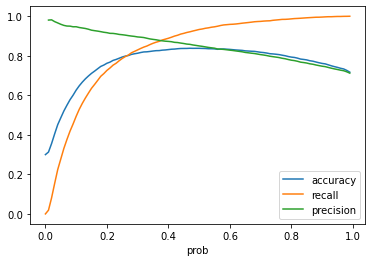

Optimum cutoff probability is 0.38
Accuracy is 0.83
Precision is 0.72
Recall is 0.71
ROC_AUC Score is 0.79

Classification report
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      5349
           1       0.72      0.71      0.71      2293

    accuracy                           0.83      7642
   macro avg       0.80      0.79      0.80      7642
weighted avg       0.83      0.83      0.83      7642

confusion matrix 

 [[4706  643]
 [ 668 1625]]


In [8]:
from sklearn.linear_model import LogisticRegression
lr = ['Logistic Regression',LogisticRegression()]
model_check(lr,X,y,sampling_type='hybrid',down_sampling_type='nearmiss',test_size=0.15,cv_search=False,info=False)

### Hyper tune the base model

Logistic Regression_RS CV
--------------------------------------------------

--------------------------------------------------
Train set After resampling Counter({0: 30311, 1: 12989})
Test set After resampling Counter({0: 5349, 1: 2293})
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   23.8s finished


Accuracy is 0.84
Precision is 0.80
Recall is 0.62
ROC_AUC Score is 0.88


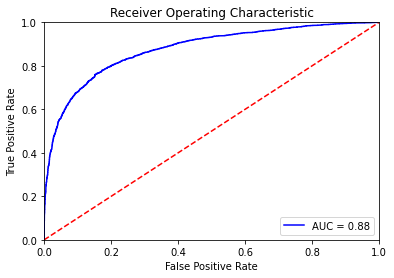


Classification report
               precision    recall  f1-score   support

           0       0.85      0.93      0.89      5349
           1       0.80      0.62      0.69      2293

    accuracy                           0.84      7642
   macro avg       0.82      0.77      0.79      7642
weighted avg       0.83      0.84      0.83      7642

confusion matrix 

 [[4991  358]
 [ 882 1411]]
--------------------------------------------------
best_parameters
{'C': 1}
--------------------------------------------------


--------------------------------------------------
--------------------------------------------------
Finding Optimal Cutoff Point based on accuracy, recall, precision


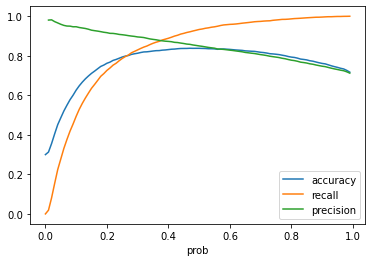

Optimum cutoff probability is 0.38
Accuracy is 0.83
Precision is 0.72
Recall is 0.71
ROC_AUC Score is 0.79

Classification report
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      5349
           1       0.72      0.71      0.71      2293

    accuracy                           0.83      7642
   macro avg       0.80      0.79      0.80      7642
weighted avg       0.83      0.83      0.83      7642

confusion matrix 

 [[4706  643]
 [ 668 1625]]


In [9]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

C = [0.001,0.01,0.1,1,2,3]

hyperparameters = dict(C=C)

lr_rcv = ['Logistic Regression_RS CV',RandomizedSearchCV(lr[1], hyperparameters, random_state=1, n_iter=1000, cv=10, verbose=1, n_jobs=-1)]
model_check(lr_rcv,X,y,sampling_type='hybrid',down_sampling_type='nearmiss',test_size=0.15,cv_search=True,info=False)

In [10]:
# adjust cutoff to increase recall

In [11]:
result

,Accuracy,Precision,Recall,AUC_ROC
Logistic Regression,0.840137,0.789227,0.637340,0.878732
Logistic Regression_RS CV,0.837739,0.797626,0.615351,0.877188


In [12]:
result_for_optimized

,Accuracy,Precision,Recall,AUC_ROC
Logistic Regression_OC,0.828448,0.71649,0.708679,0.794235
Logistic Regression_RS CV_OC,0.828448,0.71649,0.708679,0.794235


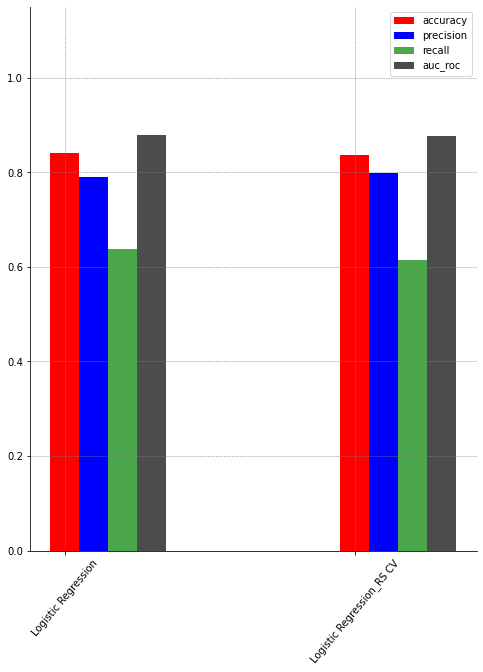

In [13]:
plt.figure(figsize=(8, 10))

ax = plt.subplot(111)

models = result.index
values = list(result['Accuracy'])
model = np.arange(len(result))

plt.bar(model, values, align='center', width = 0.1, color = 'red', label= 'accuracy')
#----------------
ax = plt.subplot(111)

models = result.index
values = list(result['Precision'])
model = np.arange(len(result))

plt.bar(model+0.1, values, align='center', width = 0.1, color = 'blue', label= 'precision')
#----------------
ax = plt.subplot(111)

models = result.index
values = list(result['Recall'])
model = np.arange(len(result))

plt.bar(model+0.2, values, align='center', width = 0.1, alpha=0.7, color = 'Green', label= 'recall')
#----------------
ax = plt.subplot(111)

models = result.index
values = list(result['AUC_ROC'])
model = np.arange(len(result))

plt.bar(model+0.3, values, align='center', width = 0.1, alpha=0.7, color = 'black', label= 'auc_roc')
plt.xticks(model, models,rotation=50,size=10)
plt.yticks(size=10)
ax.set_ylim(top=1.15)
#----------------
ax = plt.subplot(111)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc = 1,prop={'size': 10})
ax.grid(which='major',linestyle='--', linewidth='0.5', color='grey')

plt.show() 

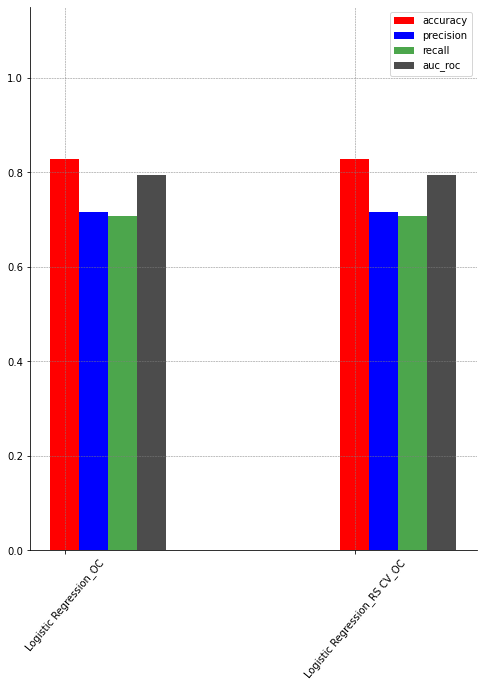

In [14]:
plt.figure(figsize=(8, 10))

ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['Accuracy'])
model = np.arange(len(result_for_optimized))

plt.bar(model, values, align='center', width = 0.1, color = 'red', label= 'accuracy')
#----------------
ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['Precision'])
model = np.arange(len(result_for_optimized))

plt.bar(model+0.1, values, align='center', width = 0.1, color = 'blue', label= 'precision')
#----------------
ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['Recall'])
model = np.arange(len(result_for_optimized))

plt.bar(model+0.2, values, align='center', width = 0.1, alpha=0.7, color = 'Green', label= 'recall')
#----------------
ax = plt.subplot(111)

models = result_for_optimized.index
values = list(result_for_optimized['AUC_ROC'])
model = np.arange(len(result_for_optimized))

plt.bar(model+0.3, values, align='center', width = 0.1, alpha=0.7, color = 'black', label= 'auc_roc')
plt.xticks(model, models,rotation=50,size=10)
plt.yticks(size=10)
ax.set_ylim(top=1.15)
#----------------
ax = plt.subplot(111)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc = 1,prop={'size': 10})
ax.grid(which='major',linestyle='--', linewidth='0.5', color='grey')

plt.show() 

In [15]:
X_rs,y_rs = re_sampling(X,y,info=False,sampling_type='hybrid',down_sampling_type='nearmiss')

In [16]:
lr_tuned = LogisticRegression(C=1,penalty='l2')

no. of estimator 1
no. of estimator 2
no. of estimator 3
no. of estimator 4
no. of estimator 5
no. of estimator 6
no. of estimator 7
no. of estimator 8
no. of estimator 9
no. of estimator 10
no. of estimator 11
no. of estimator 12
no. of estimator 13
no. of estimator 14
no. of estimator 15
no. of estimator 16
no. of estimator 17
no. of estimator 18
no. of estimator 19
no. of estimator 20
no. of estimator 21
no. of estimator 22
no. of estimator 23
no. of estimator 24
no. of estimator 25
no. of estimator 26
no. of estimator 27
no. of estimator 28
no. of estimator 29
no. of estimator 30
no. of estimator 31
no. of estimator 32
no. of estimator 33
no. of estimator 34
no. of estimator 35
no. of estimator 36
no. of estimator 37
no. of estimator 38
no. of estimator 39
no. of estimator 40
no. of estimator 41
no. of estimator 42
no. of estimator 43
no. of estimator 44
no. of estimator 45
no. of estimator 46
no. of estimator 47
no. of estimator 48
no. of estimator 49


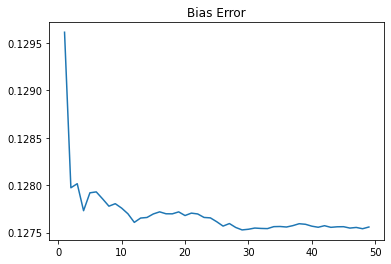

best n_estimator based on bias error =  29


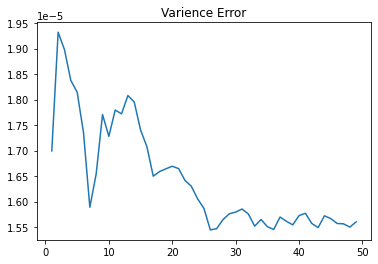

best n_estimator based on variance error =  26


In [17]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler


Bag_bias=[]
Bag_var=[]
for val in np.arange(1,50):
    Bag=BaggingClassifier(base_estimator=lr_tuned,n_estimators=val,random_state=0)
    kfold = model_selection.KFold(shuffle=True,n_splits=10,random_state=0)
    cv_results = model_selection.cross_val_score(Bag, X_rs, y_rs,cv=kfold, scoring='roc_auc')
    Bag_var.append(np.var(cv_results,ddof=1))
    Bag_bias.append(1-np.mean(cv_results))
    print(f'no. of estimator {val}')
    

    
    
x_axis=np.arange(1,50)
plt.plot(x_axis,Bag_bias)
plt.title('Bias Error')
plt.show()
print('best n_estimator based on bias error = ',(np.argmin(Bag_bias)+1))
plt.plot(x_axis,Bag_var)
plt.title('Varience Error')
plt.show()
print('best n_estimator based on variance error = ',(np.argmin(Bag_var)+1))

In [18]:
Bag_result = pd.DataFrame()
Bag_result['N-Estimators'] = np.arange(1,50)
Bag_result['Variance Error'] = Bag_var
Bag_result['Bias Error'] = Bag_bias
Bag_result.sort_values('Bias Error').head()

,N-Estimators,Variance Error,Bias Error
28,29,0.000016,0.127527
29,30,0.000016,0.127534
47,48,0.000015,0.127540
32,33,0.000016,0.127541
31,32,0.000016,0.127543


In [19]:
best_bag_est = int(Bag_result.sort_values('Bias Error').head(1)['N-Estimators'].values)
best_bag_est

29

In [20]:
Bagged_LR=['Bagged_LR',BaggingClassifier(base_estimator=lr_tuned,n_estimators=best_bag_est,random_state=0)]

Bagged_LR
--------------------------------------------------
1 of KFold 10
2 of KFold 10
3 of KFold 10
4 of KFold 10
5 of KFold 10
6 of KFold 10
7 of KFold 10
8 of KFold 10
9 of KFold 10
10 of KFold 10


     kfold  accuracy    recall  precision   ROC_AUC
1     1.0  0.836378  0.636542   0.777600  0.872389
2     2.0  0.846788  0.648330   0.802920  0.886498
3     3.0  0.838760  0.651406   0.775097  0.874835
4     4.0  0.842487  0.641596   0.793689  0.882734
5     5.0  0.837976  0.618051   0.796125  0.877434
6     6.0  0.838539  0.639162   0.782678  0.876419
7     7.0  0.838342  0.622790   0.793823  0.883343
8     8.0  0.848753  0.661428   0.799683  0.884583
9     9.0  0.841289  0.634578   0.794914  0.880139
10   10.0  0.835199  0.616241   0.788107  0.873620

Average accuracy after k-fold = 0.8404510987512561
Average recall after k-fold = 0.6370123047837851
Average precision after k-fold = 0.7904636815632643
Average ROC_AUC after k-fold = 0.8791992656596876
-------------------------------

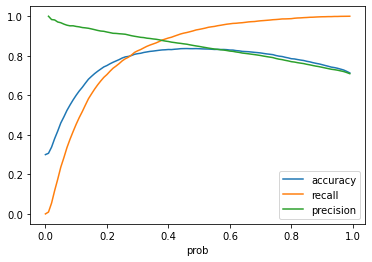

Optimum cutoff probability is 0.38
Accuracy is 0.83
Precision is 0.72
Recall is 0.71
ROC_AUC Score is 0.80

Classification report
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      5349
           1       0.72      0.71      0.72      2293

    accuracy                           0.83      7642
   macro avg       0.80      0.80      0.80      7642
weighted avg       0.83      0.83      0.83      7642

confusion matrix 

 [[4705  644]
 [ 658 1635]]


In [21]:
model_check(Bagged_LR,X,y,sampling_type='hybrid',down_sampling_type='nearmiss',test_size=0.15,cv_search=False,info=False)

no. of estimator 1
no. of estimator 2
no. of estimator 3
no. of estimator 4
no. of estimator 5
no. of estimator 6
no. of estimator 7
no. of estimator 8
no. of estimator 9
no. of estimator 10
no. of estimator 11
no. of estimator 12
no. of estimator 13
no. of estimator 14
no. of estimator 15
no. of estimator 16
no. of estimator 17
no. of estimator 18
no. of estimator 19
no. of estimator 20
no. of estimator 21
no. of estimator 22
no. of estimator 23
no. of estimator 24
no. of estimator 25
no. of estimator 26
no. of estimator 27
no. of estimator 28
no. of estimator 29
no. of estimator 30
no. of estimator 31
no. of estimator 32
no. of estimator 33
no. of estimator 34
no. of estimator 35
no. of estimator 36
no. of estimator 37
no. of estimator 38
no. of estimator 39
no. of estimator 40
no. of estimator 41
no. of estimator 42
no. of estimator 43
no. of estimator 44
no. of estimator 45
no. of estimator 46
no. of estimator 47
no. of estimator 48
no. of estimator 49


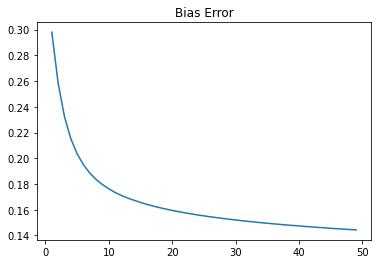

best n_estimator based on bias error =  49


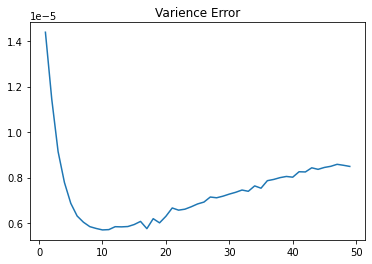

best n_estimator based on variance error =  10


In [22]:
from sklearn.ensemble import AdaBoostClassifier

Ada_lr_bias=[]
Ada_lr_var =[]
for val in np.arange(1,50):
    Ada_lr=AdaBoostClassifier(base_estimator=lr_tuned,n_estimators=val,random_state=0)
    kfold = model_selection.KFold(shuffle=True,n_splits=5,random_state=0)
    cv_results = model_selection.cross_val_score(Ada_lr, X_rs, y_rs,cv=kfold, scoring='roc_auc')
    Ada_lr_bias.append(1-np.mean(cv_results))
    Ada_lr_var.append(np.var(cv_results,ddof=1))
    print(f'no. of estimator {val}')
    

x_axis=np.arange(1,50)
plt.plot(x_axis,Ada_lr_bias)
plt.title('Bias Error')
plt.show()
print('best n_estimator based on bias error = ',(np.argmin(Ada_lr_bias)+1))
plt.plot(x_axis,Ada_lr_var)
plt.title('Varience Error')
plt.show()
print('best n_estimator based on variance error = ',(np.argmin(Ada_lr_var)+1))

In [23]:
Ada_lr_result = pd.DataFrame()
Ada_lr_result['N-Estimators'] = np.arange(1,50)
Ada_lr_result['Variance Error'] = Ada_lr_var
Ada_lr_result['Bias Error'] = Ada_lr_bias
Ada_lr_result.sort_values('Bias Error').head()

,N-Estimators,Variance Error,Bias Error
48,49,0.000008,0.144288
47,48,0.000009,0.144589
46,47,0.000009,0.144893
45,46,0.000008,0.145207
44,45,0.000008,0.145542


In [24]:
best_boost_est = int(Ada_lr_result.sort_values('Bias Error').head(1)['N-Estimators'].values)
best_boost_est

49

In [25]:
boosted_lr=['Boosted_LR',AdaBoostClassifier(base_estimator=lr_tuned,n_estimators=best_boost_est,random_state=0)]

Boosted_LR
--------------------------------------------------
1 of KFold 10
2 of KFold 10
3 of KFold 10
4 of KFold 10
5 of KFold 10
6 of KFold 10
7 of KFold 10
8 of KFold 10
9 of KFold 10
10 of KFold 10


     kfold  accuracy    recall  precision   ROC_AUC
1     1.0  0.799843  0.508186   0.743295  0.844040
2     2.0  0.816146  0.552718   0.769371  0.862404
3     3.0  0.802864  0.523872   0.743043  0.850073
4     4.0  0.809337  0.533028   0.759553  0.860230
5     5.0  0.804433  0.505559   0.762327  0.853646
6     6.0  0.811628  0.543549   0.760073  0.854319
7     7.0  0.805932  0.514080   0.761397  0.856133
8     8.0  0.812610  0.537656   0.768007  0.867086
9     9.0  0.804361  0.519974   0.751183  0.857227
10   10.0  0.800039  0.497053   0.752230  0.847989

Average accuracy after k-fold = 0.8067193785539433
Average recall after k-fold = 0.5235674578751002
Average precision after k-fold = 0.757047874369988
Average ROC_AUC after k-fold = 0.8553146851274626
-------------------------------

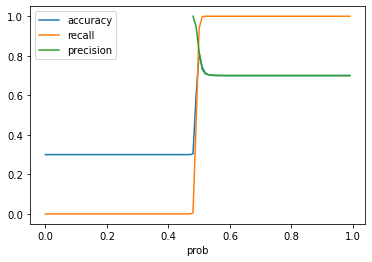

Optimum cutoff probability is 0.50
Accuracy is 0.81
Precision is 0.79
Recall is 0.52
ROC_AUC Score is 0.73

Classification report
               precision    recall  f1-score   support

           0       0.82      0.94      0.88      5349
           1       0.79      0.52      0.62      2293

    accuracy                           0.81      7642
   macro avg       0.80      0.73      0.75      7642
weighted avg       0.81      0.81      0.80      7642

confusion matrix 

 [[5025  324]
 [1108 1185]]


In [26]:
model_check(boosted_lr,X,y,sampling_type='hybrid',down_sampling_type='nearmiss',test_size=0.15,cv_search=False,info=False)

In [27]:
fin_res = pd.concat([result,result_for_optimized],axis=0)
fin_res.to_csv('fin_res_lr.csv')
fin_res

,Accuracy,Precision,Recall,AUC_ROC
Logistic Regression,0.840137,0.789227,0.637340,0.878732
Logistic Regression_RS CV,0.837739,0.797626,0.615351,0.877188
Bagged_LR,0.840451,0.790464,0.637012,0.879199
Boosted_LR,0.806719,0.757048,0.523567,0.855315
Logistic Regression_OC,0.828448,0.716490,0.708679,0.794235
Logistic Regression_RS CV_OC,0.828448,0.716490,0.708679,0.794235
Bagged_LR_OC,0.829626,0.717420,0.713040,0.796322
Boosted_LR_OC,0.812614,0.785288,0.516790,0.728109
